<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта--и-цель" data-toc-modified-id="Описание-проекта--и-цель-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта  и цель</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#План-работы" data-toc-modified-id="План-работы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>План работы</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Подготовим-датасет-для-TF-IDF" data-toc-modified-id="Подготовим-датасет-для-TF-IDF-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Подготовим датасет для TF-IDF</a></span><ul class="toc-item"><li><span><a href="#Feature-engenering" data-toc-modified-id="Feature-engenering-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Feature engenering</a></span></li></ul></li><li><span><a href="#Подготовим-датасет-для-BERT" data-toc-modified-id="Подготовим-датасет-для-BERT-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Подготовим датасет для BERT</a></span><ul class="toc-item"><li><span><a href="#Пример-кода-на-выборке-для-создания-эмбеддингов" data-toc-modified-id="Пример-кода-на-выборке-для-создания-эмбеддингов-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Пример кода на выборке для создания эмбеддингов</a></span></li><li><span><a href="#Готовый-файл-с-эмбеддингами-из-colab" data-toc-modified-id="Готовый-файл-с-эмбеддингами-из-colab-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>Готовый файл с эмбеддингами из colab</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Обучение-TF-IDF" data-toc-modified-id="Обучение-TF-IDF-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Обучение TF-IDF</a></span></li><li><span><a href="#Обучение-после-BERT" data-toc-modified-id="Обучение-после-BERT-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Обучение после BERT</a></span><ul class="toc-item"><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

## Описание проекта  и цель

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

## Описание данных 

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## План работы

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

## Подготовка

In [1]:
#импорты бибилиотек
import re 
import warnings

import torch
import joblib
import nltk
import spacy
import pandas as pd
import numpy as np
import lightgbm as lgb
import transformers as ppb
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import AutoModel, AutoTokenizer 
from tqdm import notebook
from tqdm.notebook import tqdm
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, precision_recall_curve 

warnings.filterwarnings('ignore')

In [2]:
#Константы
RANDOM_STATE = 12345
TEST_SIZE = 0.1
MAX_LENGTH=512

### Загрузка данных

In [3]:
#Прочитаем файлы:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col = [0])
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df.shape

(159292, 2)

In [5]:
df['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

In [6]:
#Посмотрим на комментарии
for i in range(5):
    print(df['text'][i])
    print()

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)

Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.

"
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or wa

In [7]:
#Уберем цифры из текста и лемматизируем его
def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text) 
    return " ".join(text.split())

df['lemm_text'] = df['text'].apply(lambda x:clear_text(x))

In [8]:
tqdm.pandas()

nlp = spacy.load("en_core_web_sm")

def spacy_lemmatize(text):
    doc = nlp(text.lower())
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

df['lemm_text'] = df['lemm_text'].progress_apply(spacy_lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [9]:
#Проверка на дубликаты
df['lemm_text'].duplicated().sum()

2298

In [10]:
df = df.drop_duplicates(subset=['lemm_text'], keep='last')

In [11]:
#Проверка на пропуски
df.isna().sum()

text         0
toxic        0
lemm_text    0
dtype: int64

In [12]:
#Посмотрим на результат очистки и лемматизации
for i in range(5):
    print(df['lemm_text'][i])
    print()

explanation edit username hardcore metallica fan revert weren t vandalism closure gas vote new york dolls fac don t remove template talk page m retire

d aww match background colour m seemingly stuck thank talk january utc

hey man m try edit war s guy constantly remove relevant information talk edit instead talk page care formatting actual info

t real suggestion improvement wonder section statistic later subsection type accident think reference need tidying exact format ie date format etc later preference format style reference want let know appear backlog article review guess delay reviewer turn s list relevant form eg wikipedia good article nomination transport

sir hero chance remember page s



In [13]:
#Визуализация облака слов
text_raw = " ".join(df['lemm_text'])

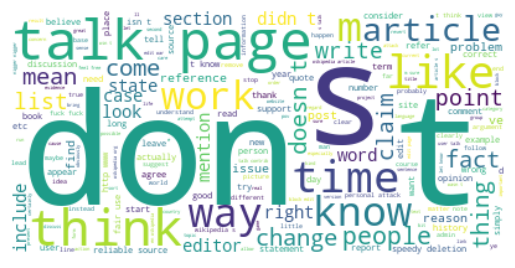

In [14]:
%matplotlib inline
stopwords = nlp.Defaults.stop_words
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_raw)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Комментарии на английском языке, текст очищен от цифр и лемматизирован. Пропусков и дубликатов нет. Виден дисбаланс классов в целевом признаке.

### Подготовим датасет для TF-IDF

#### Feature engenering

In [15]:
def make_features(data):
    
    """Принимает на вход датасет и возвращает его с новыми признаками"""
    
    data['lengh'] = data['lemm_text'].apply(lambda x: len(x))
    data['number'] = data['lemm_text'].apply(lambda x: len(x.split()))
    data['punc_number'] = data['text'].apply(lambda x: len([i for i in x if i in '!@#$\n-.,']))
    data['upper_number'] = data['text'].apply(lambda x: len([i for i in x if i.isupper()])) 
    return data  

In [16]:
df = make_features(df)
df.head()

,text,toxic,lemm_text,lengh,number,punc_number,upper_number
0,Explanation\nWhy the edits made under my usern...,0,explanation edit username hardcore metallica f...,150,25,7,17
1,D'aww! He matches this background colour I'm s...,0,d aww match background colour m seemingly stuc...,70,12,5,8
2,"Hey man, I'm really not trying to edit war. It...",0,hey man m try edit war s guy constantly remove...,123,21,4,4
3,"""\nMore\nI can't make any real suggestions on ...",0,t real suggestion improvement wonder section s...,324,47,14,11
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page s,31,6,3,2


In [17]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\649\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
new_features = ['lengh', 'number', 'punc_number', 'upper_number']

features = ColumnTransformer(
                    [("text_preprocess", TfidfVectorizer(stop_words=stopwords), 'lemm_text'),
                     ("new_features_preprocess", StandardScaler(), new_features)])

In [19]:
pipeline_logreg = Pipeline([('features_all_prepross', features),
                 ('clf', LogisticRegression(random_state = RANDOM_STATE))])

pipeline_gbr = Pipeline([('features_all_prepross', features),
                 ('clf', lgb.LGBMClassifier(random_state = RANDOM_STATE))])

In [20]:
#Разделим датасет на выборки
train_tf_idf, test_tf_idf = train_test_split(df, test_size = TEST_SIZE, random_state = RANDOM_STATE, 
                                             stratify = df['toxic']) 

In [21]:
#Проверка на корректность разбиения выборок
train_tf_idf.shape[0] + test_tf_idf.shape[0] == len(df)

True

In [22]:
#Распределение классов
test_tf_idf['toxic'].value_counts(normalize=True)

0    0.898408
1    0.101592
Name: toxic, dtype: float64

### Подготовим датасет для BERT

Так как BERT долго обрабатывает эмбеддинги и мой компьютер не вывозит и зависает я создала эмбеддинги в colab, сохранила их в файл и в этой части работы сразу загружаю этот файл. Прилагаю код для получения эмбеддингов ниже (на выборке, чтоб было быстрее).

#### Пример кода на выборке для создания эмбеддингов

In [23]:
df_bert = df[['text', 'toxic']].sample(200).reset_index(drop=True)
df_bert['toxic'].value_counts(normalize=True)

0    0.91
1    0.09
Name: toxic, dtype: float64

In [24]:
# Загрузка предобученной модели BERT и токенайзера
model_name = "unitary/toxic-bert" 

model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
tqdm.pandas()
tokenized = df_bert['text'].progress_apply(
    lambda x: tokenizer.encode(x, max_length=MAX_LENGTH, truncation=True, add_special_tokens=True))

padded = np.array([i + [0]*(MAX_LENGTH - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

  0%|          | 0/200 [00:00<?, ?it/s]

In [26]:
batch_size = 50
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/4 [00:00<?, ?it/s]

In [27]:
features = np.concatenate(embeddings)

df_bert = pd.concat([pd.DataFrame(features), df_bert['toxic']], axis=1)
df_bert.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,toxic
0,-0.625053,-0.960123,0.570177,-0.402951,1.166516,0.296516,-0.109077,-0.150913,-0.455305,-0.738905,...,-1.281053,0.369401,-0.651859,0.192129,0.792814,-0.344645,-0.658774,0.496141,0.031735,0
1,-0.285529,0.670813,1.140428,0.498519,-0.384031,0.724425,0.391701,-0.026661,-0.161180,0.130758,...,0.172230,-0.769694,0.255282,-1.093025,-1.059564,0.265524,-0.819010,-0.188569,-0.032949,1
2,-0.716266,-0.914759,0.587127,-0.495930,1.067457,0.322228,-0.057303,-0.015553,-0.362615,-0.448007,...,-1.200395,0.091735,-0.712413,0.146879,0.927424,-0.460066,-0.704022,0.531128,0.150722,0
3,-0.653666,-0.827810,0.452052,-0.344707,1.047531,0.692659,0.303831,0.375998,-0.540917,-0.106752,...,-0.552660,-0.012801,-0.383069,-0.371735,0.069594,-0.545181,-0.252501,0.932675,0.273749,0
4,-0.230025,0.311989,0.685176,-0.066347,-0.257801,0.547494,1.265525,0.826269,-0.320583,0.184608,...,0.727019,-0.617782,-0.915360,-0.448423,-0.439910,-0.067522,-0.355557,0.393284,0.403140,1


#### Готовый файл с эмбеддингами из colab

Прочитаем готовый файл с эмбеддингами с гугл-диска:  
https://drive.google.com/file/d/1e2AGmpxgvGeroZnLo-wH8NgnTNnU0YtW/view?usp=sharing

In [28]:
! pip install gdown

In [29]:
! gdown 1e2AGmpxgvGeroZnLo-wH8NgnTNnU0YtW --output toxic_bert.csv

Downloading...
From: https://drive.google.com/uc?id=1e2AGmpxgvGeroZnLo-wH8NgnTNnU0YtW
To: C:\Users\649\Yandex\Projects\Проект для «Викишоп»\toxic_bert.csv

  0%|          | 0.00/1.35G [00:00<?, ?B/s]
  0%|          | 524k/1.35G [00:00<06:45, 3.34MB/s]
  0%|          | 1.57M/1.35G [00:00<03:38, 6.20MB/s]
  0%|          | 2.62M/1.35G [00:00<03:26, 6.54MB/s]
  0%|          | 4.19M/1.35G [00:00<02:40, 8.41MB/s]
  0%|          | 5.77M/1.35G [00:00<02:23, 9.41MB/s]
  1%|          | 7.34M/1.35G [00:00<02:12, 10.2MB/s]
  1%|          | 8.91M/1.35G [00:00<02:05, 10.7MB/s]
  1%|          | 10.5M/1.35G [00:01<02:02, 10.9MB/s]
  1%|          | 12.1M/1.35G [00:01<01:59, 11.2MB/s]
  1%|1         | 13.6M/1.35G [00:01<01:57, 11.4MB/s]
  1%|1         | 15.2M/1.35G [00:01<01:56, 11.4MB/s]
  1%|1         | 16.8M/1.35G [00:01<01:55, 11.5MB/s]
  1%|1         | 18.4M/1.35G [00:01<01:53, 11.8MB/s]
  1%|1         | 19.9M/1.35G [00:01<01:55, 11.5MB/s]
  2%|1         | 21.5M/1.35G [00:02<02:04, 10.7MB/s]
  2%|1

In [30]:
toxic_bert = pd.read_csv('toxic_bert.csv',
                         dtype = 'float32')
toxic_bert['toxic'] = toxic_bert['toxic'].astype(int)

toxic_bert.tail()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,toxic
159287,-0.652741,-0.823988,0.711186,-0.576176,1.075303,0.451535,0.107537,-0.173059,-0.463752,-0.621503,...,-1.265418,0.330924,-0.748394,0.068725,0.653005,-0.505580,-0.558983,0.582910,0.090834,0
159288,-0.419275,-0.410370,0.182845,-0.518281,0.734251,0.357042,0.837733,0.611174,-0.252815,-0.276888,...,-0.159254,0.267569,-0.698631,-0.151435,0.443611,-0.436761,-0.510881,0.587998,0.569564,0
159289,-0.662477,-0.769980,0.659574,-0.237460,0.984435,0.659845,0.261784,0.169605,-0.240536,-0.088890,...,-0.746108,0.154554,-0.783863,-0.513483,0.171453,-0.192064,-0.829304,0.601079,0.385463,0
159290,-0.436348,-0.762226,0.804334,-0.491034,1.024915,0.451657,0.294450,0.100604,-0.503652,-0.705745,...,-1.120216,0.132425,-0.487368,0.139159,0.704780,-0.573861,-0.677695,0.696261,0.262119,0
159291,-0.472370,-0.795974,0.720383,-0.424006,1.261695,0.353613,0.426531,-0.008906,-0.389145,-0.944077,...,-1.073633,0.351289,-0.598805,0.010931,0.604143,-0.442668,-0.652688,0.615764,0.214165,0


In [31]:
toxic_bert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Columns: 769 entries, 0 to toxic
dtypes: float32(768), int32(1)
memory usage: 467.3 MB


In [32]:
#Проверка корректности загрузки файла
sum(toxic_bert.isna().sum())

0

Сделаем выборку в 20 000 так как обучение на всех эмбеддингах очень долгое и прерывается с ошибкой.

In [33]:
toxic_bert_sam = toxic_bert.sample(20000).reset_index(drop=True)
toxic_bert_sam['toxic'].value_counts(normalize=True)

0    0.90005
1    0.09995
Name: toxic, dtype: float64

In [34]:
#Разделим датасет на выборки
train_bert, test_bert = train_test_split(toxic_bert_sam, test_size = TEST_SIZE, random_state = RANDOM_STATE, 
                                         stratify = toxic_bert_sam['toxic']) 

In [35]:
#Проверка на корректность разбиения
len(train_bert) + len(test_bert)

20000

In [36]:
#Опять проверяем как распределены классы в целевом признаке
test_bert['toxic'].value_counts(normalize=True)

0    0.9
1    0.1
Name: toxic, dtype: float64

## Обучение

In [37]:
def model_selection(grid, grid_dict, X_train, y_train):
    
    """Принимает на вход сетку гиперпараметров для каждого класса моделей и соответствующий словарь с названиями моделей. 
    Возвращает параметры лучшей модели в каждом классе."""
    
    result = []
    
    for i in range(len(grid_dict)):
        grid[i].fit(X_train, y_train)
        result.append([grid_dict[i], abs(grid[i].best_score_)])
        
    return pd.DataFrame(result, columns = ['model', 'f1'])

In [38]:
#Проверим модель на адекватность константным прогнозом
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_tf_idf, train_tf_idf['toxic'])

f1_score(test_tf_idf['toxic'], dummy_clf.predict(test_tf_idf))

0.0

### Обучение TF-IDF

In [39]:
# параметры кросс-валидации (стратифицированная 5-фолдовая с перемешиванием) 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [40]:
#Логистическая регрессия
params = {
          'clf__C' : sp_randFloat(),
          'clf__class_weight':['balanced']
          }

logreg_tf_idf = RandomizedSearchCV(pipeline_logreg, params,  n_iter=10, scoring='f1', n_jobs=-1, cv = skf, error_score='raise')

#Градиентный бустинг
params = {
          'clf__learning_rate': sp_randFloat(),
          'clf__max_depth' : sp_randInt(2, 20),
          'clf__class_weight':['balanced'],
          'clf__n_jobs': [-1]}

gbr_tf_idf = RandomizedSearchCV(pipeline_gbr, params,  n_iter=10, scoring='f1', n_jobs=-1, cv = skf, error_score='raise')

grid_tf_idf = [logreg_tf_idf, gbr_tf_idf]
grid_dict = {0: 'LogisticRegression', 1:'LGBMClassifier'}

In [41]:
%%time
result_tf_idf = model_selection(grid_tf_idf, grid_dict, train_tf_idf, train_tf_idf['toxic'])

CPU times: total: 4min 35s
Wall time: 15min 4s


In [42]:
result_tf_idf

,model,f1
0,LogisticRegression,0.750338
1,LGBMClassifier,0.753759


### Обучение после BERT

In [43]:
#Логистическая регрессия
params = {
          'solver' : ['saga'],
          'penalty' : ['l1', 'l2', 'none'],
          'fit_intercept' : [True, False],
          'C' : sp_randFloat(),
          'class_weight':['balanced', None],
          }



logreg_b = RandomizedSearchCV(LogisticRegression(random_state=RANDOM_STATE), params,  n_iter=30, scoring='f1', n_jobs=-1, 
                              cv = skf, error_score='raise')


#Градиентный бустинг
params = {
          'learning_rate': sp_randFloat(),
          'max_depth' : sp_randInt(2, 20),
          'reg_alpha':sp_randFloat(),
          'min_child_samples':sp_randInt(2, 50),
          'class_weight':['balanced', None],
          'n_jobs': [-1]}

gbr_b = RandomizedSearchCV(lgb.LGBMClassifier(random_state=RANDOM_STATE), params,  n_iter=30, scoring='f1', n_jobs=-1, cv = skf, 
                           error_score='raise')

grid_b = [logreg_b, gbr_b]
grid_dict = {0: 'LogisticRegression', 1:'LGBMClassifier'}

In [44]:
%%time
result_bert = model_selection(grid_b, grid_dict, train_bert.drop('toxic', axis = 1), train_bert['toxic'])

CPU times: total: 45 s
Wall time: 17min 30s


In [45]:
result_bert

,model,f1
0,LogisticRegression,0.949129
1,LGBMClassifier,0.942712


Лучшая модель - LogisticRegression, обученная на эмбеддингах, полученные при помощи toxic bert, с результатом f1 = 0.94, оценим ее на тестовой выборке и осуществим подбор порога классификации.

In [46]:
logreg_b.best_params_

{'C': 0.11428389652978854,
 'class_weight': None,
 'fit_intercept': True,
 'penalty': 'l2',
 'solver': 'saga'}

In [47]:
#Для подбора порога выделим валидационную выборку
train, valid  = train_test_split(train_bert, test_size = TEST_SIZE, random_state = RANDOM_STATE, stratify = train_bert['toxic'])

In [48]:
best_model = LogisticRegression(C = 0.44, class_weight = None, fit_intercept = False, penalty = 'l1', 
                                solver = 'saga').fit(train.drop('toxic', axis = 1), train['toxic'])

In [49]:
def threshold_selection(model, max_threshold):
    
    """Функция для подбора оптимального порога классификации"""
    
    thresholds = {}
    probabilities_valid = model.predict_proba(valid.drop('toxic', axis = 1))
    probabilities_one_valid = probabilities_valid[:, 1]
    
    for threshold in np.arange(0, 1, 0.01):
        predicted_valid = probabilities_one_valid > threshold 
        f1 = f1_score(valid['toxic'], predicted_valid)
        thresholds[f1] = []
        thresholds[f1].append(threshold)
    
    return f"Лучшие результаты при threshold={thresholds[max(thresholds)][0]} f1={max(thresholds)}"

In [50]:
threshold_selection(best_model, 1)

'Лучшие результаты при threshold=0.49 f1=0.9516129032258064'

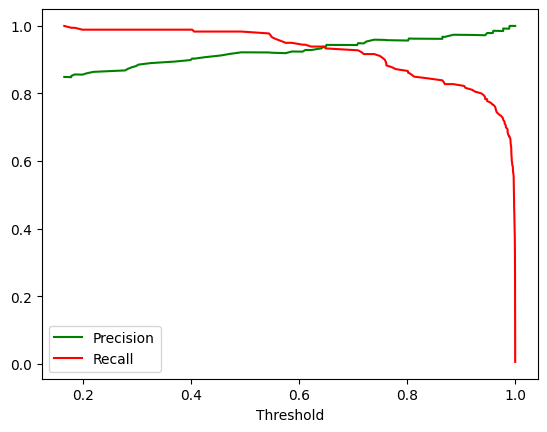

In [51]:
#Для лучшей модели построим precision_recall_curve
precision, recall, thresholds = precision_recall_curve(valid['toxic'], best_model.predict_proba(valid.drop('toxic', 
                                                                                                           axis = 1))[:, 1])
plt.plot(thresholds, precision[:-1], "g-", label="Precision")
plt.plot(thresholds, recall[:-1], "r-", label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.show()

#### Тестирование модели

In [53]:
f1_score(test_bert['toxic'], best_model.predict(test_bert.drop('toxic', axis = 1)))

0.9576059850374063

## Выводы

На первоначальном этапе были загружены данные. Датасет с комментариями на английском языке размером 159292 строк. Наблюдается дисбаланс в целевом признаке - токсичных комментариев около 10%.  

Для обработки данных использовались два подхода:  
1. TF-IDF  
Для использования этого подхода комментарии были предобработаны - очищены от цифр, проведена лемматизация. После проверки на дубликаты удалено 1337 строк. 
2. BERT  
На основе исходных данных созданы эмбеддинги при помощи DistilBert, которые далее использовались как признаки для обучения моделей. На этапе подбора моделей использовалась выборка 60 000 строк, так как для использования полных данных требуется более совершенная техника :)

Константный прогноз составил f1 = 0.0  

В таблице приведены результаты метрики f1 различных моделей, полученные при помощи кросс-валидации:

| Модель | tf-idf | BERT(60 000) | 
| --- | --- | --- |
| LogisticRegression | 0.750 | 0.949 | 
| LGBMClassifier | 0.754 | 0.943 | 

Лучшая модель - LogisticRegression (обученная на эмбеддингах от toxic bert) с результатом f1 = 0.93 на кросс-валидации была проверена на тестовой выборке. Метрика  на тестовых данных составила f1 = 0.96. 